## **Setup**

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

# **Build the encoder**

In [27]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(227, 227, 3))
x = layers.Conv2D(96, 11, 4, activation='relu')(encoder_inputs)
#x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(96, 3, strides = 2, activation='relu')(x)
#x = layers.MaxPooling2D(2, 2)(x)

x = layers.Conv2D(256, 5, 1,padding = "same", activation='relu')(x)

x = layers.Conv2D(256, 3, 2, activation='relu')(x)

x = layers.Conv2D(384, 3, 1,padding = "same", activation='relu')(x)
x = layers.Conv2D(384, 3, 1,padding = "same", activation='relu')(x)
x = layers.Conv2D(256, 3, 2, activation='relu')(x)

x = layers.Flatten()(x)

x = layers.Dense(4096, activation='relu')(x)
x = layers.Dropout(0.5)(x)


z = layers.Dense(latent_dim, name="z")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)          │ (None, 227, 227, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_119 (Conv2D)                  │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_120 (Conv2D)                  │ (None, 27, 27, 96)          │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_121 (Conv2D)                  │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_122 (Conv2D)                  │ (None, 13, 13, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_123 (Conv2D)                  │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_124 (Conv2D)                  │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_125 (Conv2D)                  │ (None, 6, 6, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ z (Dense)                            │ (None, 4)                   │          16,388 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,189,540 (160.94 MB)

 Trainable params: 42,189,540 (160.94 MB)

 Non-trainable params: 0 (0.00 B)

# **Build the decoder**

In [42]:
latent_dim = 4

decoder_inputs = keras.Input(shape=(latent_dim,))


x = layers.Dense(4096, activation='relu')(decoder_inputs)
x = layers.Dropout(0.5)(x)

x = layers.Dense(6 * 6 * 256, activation='relu')(x)
x = layers.Reshape((6, 6, 256))(x)

x = layers.Conv2DTranspose(256, 3, 2, activation='relu')(x)
x = layers.Conv2DTranspose(384, 3, 1,padding = "same", activation='relu')(x)
x = layers.Conv2DTranspose(384, 3, 1,padding = "same", activation='relu')(x)
x = layers.Conv2DTranspose(256, 3, 2, activation='relu')(x)

x = layers.Conv2DTranspose(256, 5, 1,padding = "same", activation='relu')(x)
x = layers.Conv2DTranspose(96, 3, strides = 2, activation='relu')(x)
decoder_outputs = layers.Conv2DTranspose(96, 11, 4, activation='sigmoid')(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)          │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 4096)                │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 9216)                │      37,757,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_15 (Reshape)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_112                 │ (None, 13, 13, 256)         │         590,080 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_113                 │ (None, 13, 13, 384)         │         885,120 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_114                 │ (None, 13, 13, 384)         │       1,327,488 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_115                 │ (None, 27, 27, 256)         │         884,992 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_116                 │ (None, 27, 27, 256)         │       1,638,656 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_117                 │ (None, 55, 55, 96)          │         221,280 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_118                 │ (None, 227, 227, 96)        │       1,115,232 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,441,280 (169.53 MB)

 Trainable params: 44,441,280 (169.53 MB)

 Non-trainable params: 0 (0.00 B)

# **Define the AE as a Model with a custom train_step**

In [ ]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            mse_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
            per_pixel_loss = mse_loss(data, reconstruction)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(per_pixel_loss, axis=[1, 2])  # Sum over height & width, averaging over channels
            )


            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
        }

# **Load Dataset from kaggle**

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/GenAI_Assign_1/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download arpitjain007/dog-vs-cat-fastai


cp: cannot stat '/content/drive/MyDrive/GenAI_Assign_1/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/arpitjain007/dog-vs-cat-fastai
License(s): unknown
100% 1.60G/1.60G [01:18<00:00, 21.8MB/s]
100% 1.60G/1.60G [01:18<00:00, 21.9MB/s]


In [ ]:
!unzip /content/dog-vs-cat-fastai.zip

Streaming output truncated to the last 5000 lines.
  inflating: dogscats/train/dogs/dog.7066.jpg  
  inflating: dogscats/train/dogs/dog.7067.jpg  
  inflating: dogscats/train/dogs/dog.7068.jpg  
  inflating: dogscats/train/dogs/dog.7069.jpg  
  inflating: dogscats/train/dogs/dog.707.jpg  
  inflating: dogscats/train/dogs/dog.7070.jpg  
  inflating: dogscats/train/dogs/dog.7071.jpg  
  inflating: dogscats/train/dogs/dog.7072.jpg  
  inflating: dogscats/train/dogs/dog.7073.jpg  
  inflating: dogscats/train/dogs/dog.7074.jpg  
  inflating: dogscats/train/dogs/dog.7075.jpg  
  inflating: dogscats/train/dogs/dog.7076.jpg  
  inflating: dogscats/train/dogs/dog.7077.jpg  
  inflating: dogscats/train/dogs/dog.7078.jpg  
  inflating: dogscats/train/dogs/dog.7079.jpg  
  inflating: dogscats/train/dogs/dog.708.jpg  
  inflating: dogscats/train/dogs/dog.7080.jpg  
  inflating: dogscats/train/dogs/dog.7081.jpg  
  inflating: dogscats/train/dogs/dog.7082.jpg  
  inflating: dogscats/train/dogs/dog.70

# **Train the AE**

In [ ]:
import tensorflow as tf
import numpy as np

# Define dataset paths
train_dir = "/content/dogscats/dogscats/train"  # Update this path
val_dir = "/content/dogscats/dogscats/valid"

# Load training dataset (RGB, keeps class structure)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(227, 227),  # Resize to match the VAE input shape
    batch_size=128,
    shuffle=True
)

# Load validation dataset
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(227, 227),
    batch_size=128,
    shuffle=True
)

def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  #
    return image  # Ignore the label

train_dataset = train_dataset.map(normalize)
val_dataset = val_dataset.map(normalize)




Found 23000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
ae = AE(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam())
history = ae.fit(train_dataset, epochs=100, batch_size=128)

Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 213s 878ms/step - loss: 0.0672 - reconstruction_loss: 0.0672
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 178s 673ms/step - loss: 0.0621 - reconstruction_loss: 0.0621
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 123s 685ms/step - loss: 0.0398 - reconstruction_loss: 0.0398
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 124s 687ms/step - loss: 0.0386 - reconstruction_loss: 0.0386
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 141s 680ms/step - loss: 0.0383 - reconstruction_loss: 0.0383
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 141s 678ms/step - loss: 0.0381 - reconstruction_loss: 0.0381
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 124s 690ms/step - loss: 0.0379 - reconstruction_loss: 0.0379
Epoch 8/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 125s 693ms/step - loss: 0.0379 - reconstruction_loss: 0.0379
Epoch 9/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 143s 695ms/step - loss: 0.0378 - reconstruction_loss: 0.0378
Epoch 10/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 125s 694ms/step - loss: 0.0378 - reconst

In [ ]:
ae.build(input_shape=(None, 227, 227, 3))
f_name = "/content/ae.weights.h5"
ae.save_weights("/content/ae.weights.h5")
!mv "/content/ae.weights.h5" /content/drive/MyDrive/



# **Display**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to your test images
image_dir = "/content/dogscats/test1"
image_size = (227, 227)  # Match model input size
num_samples = 25


image_files = sorted(os.listdir(image_dir))[:num_samples]  # Load first 'num_samples' images

sample_images = []
for img_name in image_files:
    img_path = os.path.join(image_dir, img_name)
    img = load_img(img_path, target_size=image_size)
    img = img_to_array(img) / 255.0
    sample_images.append(img)

sample_images = np.array(sample_images)

print(f"Loaded {sample_images.shape[0]} images of shape {sample_images.shape[1:]}")


Loaded 25 images of shape (224, 224, 3)


In [ ]:

encoded_images = ae.encoder.predict(sample_images, verbose=0)
decoded_images = ae.decoder.predict(encoded_images, verbose=0)


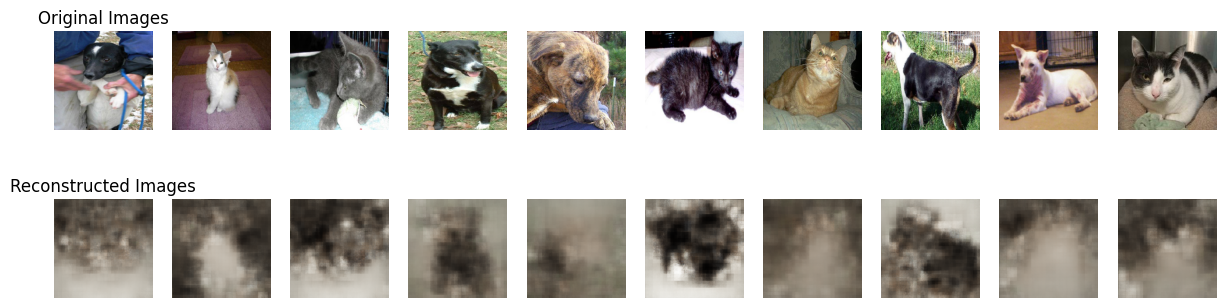

In [ ]:
# Plot original vs reconstructed images
n = min(num_samples, 10)
fig, axes = plt.subplots(2, n, figsize=(15, 4))

for i in range(n):
    # Original Image
    axes[0, i].imshow(sample_images[i])
    axes[0, i].axis("off")

    # Reconstructed Image
    axes[1, i].imshow(decoded_images[i])
    axes[1, i].axis("off")

axes[0, 0].set_title("Original Images")
axes[1, 0].set_title("Reconstructed Images")
plt.show()


In [ ]:
# Compute Mean Squared Error (MSE)
mse = np.mean(np.square(sample_images - decoded_images))
print(f"Reconstruction MSE: {mse:.6f}")


Reconstruction MSE: 0.044246


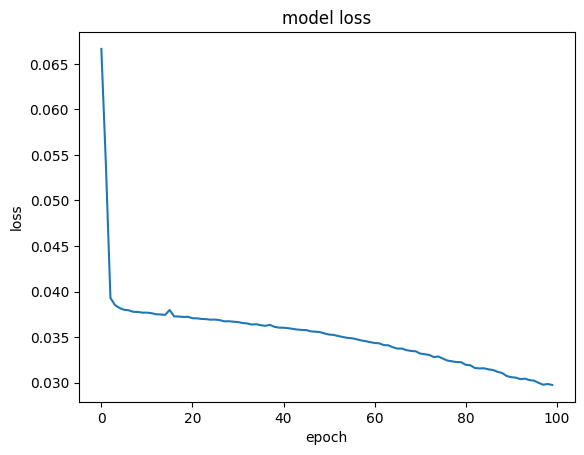

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['reconstruction_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
